https://docs.fast.ai/tutorial.datablock
https://docs.fast.ai/tutorial.imagenette.html

Carrega o melhor modelo e passa pelo conjunto de teste com imagens que não passaram no treinamento

In [52]:
from fastai.vision.all import *
# from fastai import interpret_2
from fastai.torch_core import *
from fastai.learner import *
import torchvision.transforms as T
import torchvision
import csv
import numpy as np

import pandas as pd
path = Path(r'/home/eferreira/master/mestrado_cnn/projeto_final/semantic_segmentation/dataset')
fnames_train = get_image_files(path/'test/')
fnames_val = get_image_files(path/'test/')

fnames = get_image_files(path/'test/')
for item in fnames_train:
  fnames.append(item)
# print(fnames)
codes = array(['void','corrosion'], dtype='<U17')
# def label_func(fn): return path/'labels'/f'{fn.stem}.png'
train = 'test'
valid = 'test'
def label_func(fn): return Path(str(fn.parent)+'_label')/f'{fn.stem}_label_ground-truth_semantic.png'

_cmap = {
         0: (0, 0, 0),      
        1: (164, 0, 128)}       # corrosion
           
_mask_labels = {0: 'void',1: 'corrosion'}
# 

# Cell
def _parent_idxs(items, name):
    def _inner(items, name): return mask2idxs(Path(o).parent.name == name for o in items)
    return [i for n in L(name) for i in _inner(items,n)]

# Cell
def ParentSplitter(train_name='test', valid_name='test'):
    "Split `items` from the parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _parent_idxs(o, train_name),_parent_idxs(o, valid_name)
    return 

class SegmentationCustomDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for segmentation problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, label_func, train='test', valid='test', valid_pct=None, seed=None, codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                           splitter=ParentSplitter(train_name=train, valid_name=valid),
                           get_items = partial(get_image_files, folders=[train, valid]),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, path, path=path, **kwargs)
        return res 




dls = SegmentationCustomDataLoaders.from_label_func(

        path, label_func = label_func, codes = codes, bs=1, batch_tfms=aug_transforms(), num_workers=2

    )



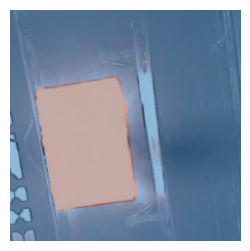

In [53]:
dls.show_batch(max_n=15)

Declaração das métricas

In [54]:
class accuracy_bgd(Metric):
    def __init__(self, axis=1): self.axis = axis    
    def reset(self): self.TP, self.FN, self.TN, self.FP, self.info = 0,0,0,0,pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN'])
    def accumulate(self, learn):
        
        y_pred, y_true = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
       

        self.TP += len(np.where(y_pred + y_true ==2)[0])
        self.FN += len(np.where(y_pred - y_true  == 1)[0])
        self.TN += len(np.where(y_pred + y_true == 0)[0])
        self.FP += len(np.where(y_pred - y_true  == -1)[0])
        # save_data(self.TP, self.FN, self.TN, self.FP)
        dataf = {'TP': self.TP, 'TN':self.TN, 'FP':self.FP, 'FN':self.FN}
    
        self.info = self.info.append(dataf, ignore_index=True)
        self.info.to_csv(r"C:\Users\miningrig0\Documents\tcc\src3\segments\eferreira_corrosion\v3_final_pytorch\temp\data.csv")


    @property
    def value(self):
        
        return ((self.TP + self.TN) / (self.TP + self.FN + self.TN + self.FP)) if (self.TP + self.FN + self.TN + self.FP) > 0 else 0


In [55]:

class precision(Metric):
    def __init__(self, axis=1): self.axis = axis    
    def reset(self): self.FP, self.TP = 0,0
    def accumulate(self, learn):
        y_pred, y_true = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        self.TP += len(np.where(y_pred + y_true ==2)[0])
        self.FP += len(np.where(y_pred - y_true  == -1)[0])
       
        
        if self.FP < 0:
            self.FP *= -1
            
    @property    
    def value(self):
        
        return self.TP / (self.TP + self.FP) if (self.TP + self.FP) > 0 else 0


In [56]:

class recall(Metric):
    def __init__(self, axis=1): self.axis = axis    
    def reset(self): self.FN, self.TP = 0,0
    def accumulate(self, learn):
        y_pred, y_true = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)  

        self.TP += len(np.where(y_pred + y_true ==2)[0])
        self.FN += len(np.where(y_pred - y_true  == 1)[0])
        
    @property
    def value(self):
        return  self.TP/(self.FN + self.TP) if (self.FN + self.TP) > 0 else 0  
    

In [57]:

def dice(y_pred, y_true):
    
    TP = len(np.where(y_pred + y_true ==2)[0])
    FN = len(np.where(y_pred - y_true  == 1)[0])
    TN = len(np.where(y_pred + y_true == 0)[0])
    FP = len(np.where(y_pred - y_true  == -1)[0])      
         
    return (2*TP)/((2*TP)+FP + FN) if ((2*TP)+FP + FN) > 0 else 0

In [58]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):
    
    "Computes non-background accuracy for multiclass segmentation"
    targ = cast(targ.squeeze(1), TensorBase)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()

In [59]:
def tp_tn_fp_fn(y_true,y_pred):

    TP = len(np.where(y_pred + y_true ==2)[0])
    FN = len(np.where(y_pred - y_true  == 1)[0])
    TN = len(np.where(y_pred + y_true == 0)[0])
    FP = len(np.where(y_pred - y_true  == -1)[0])
    return TP, TN, FP, FN

In [60]:

metrics= {JaccardCoeff, Dice, foreground_acc, accuracy_bgd, precision, recall}
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics)

In [61]:
learn.load('strip_segmentation')


In [62]:
def write_to_csv(accuracy, jaccard,dice,f1score,precision,recall):

    # header = ['tp', 'tn', 'fp', 'fn']
    data = [accuracy, jaccard,dice,f1score,precision,recall]

    with open(r"/home/eferreira/master/mestrado_cnn/projeto_final/semantic_segmentation/results/data.csv", 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(data)

In [63]:
def is_binary(tensor):
    """
    Check if a tensor is binary (contains only 0 and 1).

    Args:
    tensor (torch.Tensor): The tensor to check.

    Returns:
    bool: True if the tensor is binary, False otherwise.
    """
    return torch.all((tensor == 0) | (tensor == 1)).item()


In [64]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, accuracy_score
from PIL import Image
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt

def label_func(fn): 
    return Path(str(fn.parent) + '_label') / f'{fn.stem}_label_ground-truth_semantic.png'

def show_my_predictions(original):
    original = Path(str(original))
    targ = label_func(original)
    # print(targ)
  
    original_pred = original
    original = Image.open(original)
    pred = learn.predict(original_pred)[1]
    targ = Image.open(targ)

    print(targ)
    

    convert_tensor = transforms.ToTensor()
    targ = convert_tensor(targ)
    

    targ = targ.squeeze()
    targ_plot = targ
    pred = pred.squeeze()
    
    # threshold = 0.8
    # pred = (pred >= threshold).to(torch.int) 
    # # Verificar os valores únicos no target

    # if not set(unique_values.tolist()).issubset({0, 1}):
    targ = (targ > 0).int()
    # print("Target após mapeamento para valores binários:", torch.unique(targ))

    unique_values = torch.unique(targ)
    # print("Valores únicos no target:", unique_values)
    # targ = targ.int()

    # Convert to numpy arrays for metric calculations
    # print(f"target shape: {targ.shape} pred shape: {pred.shape}")
    targ_calc = targ.cpu().numpy().flatten()
    pred_calc = pred.cpu().numpy().flatten()

    assert set(np.unique(targ_calc)).issubset({0, 1}), "Predictions contain values other than 0 and 1 after thresholding."

    # print(targ_calc, pred_calc)


    precision = round(precision_score(targ_calc, pred_calc, average='micro'), 3)
    recall = round(recall_score(targ_calc, pred_calc, average='micro'), 3)
    f1score = round(f1_score(targ_calc, pred_calc, average='micro'), 3)
    jaccard = round(jaccard_score(targ_calc, pred_calc, average='micro'), 3)
    
    original = convert_tensor(original)
    original = original.permute(1, 2, 0)
    

    dice_coef = round(dice(pred_calc, targ_calc), 3)
    
    tp, tn, fp, fn = tp_tn_fp_fn(pred, targ)
    accuracy = round((tp + tn) / (tp + tn + fp + fn), 3)    

    # write_to_csv(accuracy, jaccard, dice_coef, f1score, precision, recall)
    # print(accuracy, jaccard, dice_coef, f1score, precision, recall)
    # print(round(accuracy_score(targ_calc, pred_calc), 3))
    text = f"Acc: {accuracy}, jaccard: {jaccard}, dice: {dice_coef}, f1: {f1score}, precision: {precision}, recall: {recall}"
    
     # Adding target mask to the images tuple
    images = (original, targ_plot, pred)
   
    plt.figure(figsize=(30, 30))
    title = ['Input Image', 'Target Mask', 'Predicted Mask', 'Overlayed']
    
    for i in range(len(images) + 1):
        plt.subplot(1, len(images) + 1, i + 1)
        plt.title(title[i])
        if title[i] == "Overlayed" and i == 3:
            plt.imshow(images[0])
            plt.imshow(images[2], alpha=0.4, cmap='plasma')
            plt.axis('off')
        else:
            if i < 4:
                plt.imshow(images[i].cpu().numpy(), cmap='plasma')
                plt.axis('off')
            else:
                continue
    plt.text(-620, 232, text, fontsize=15, ha='center')
    plt.show()



<PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>


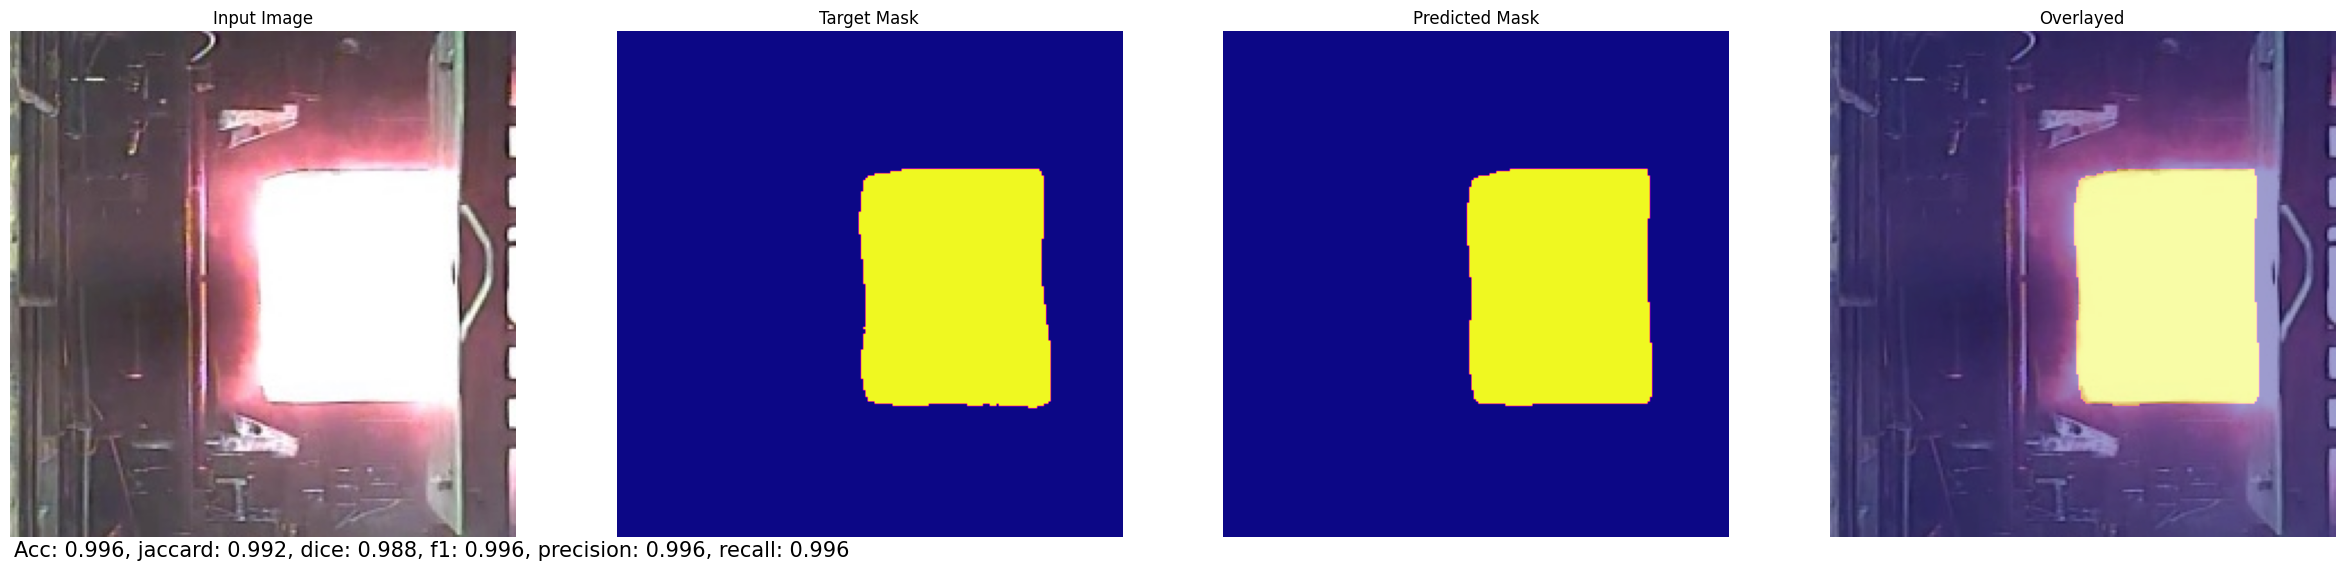

In [65]:
show_my_predictions(r"/home/eferreira/master/mestrado_cnn/projeto_final/semantic_segmentation/dataset/test/F1_SUP_TOPO_002_M915449.jpg")

<PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>


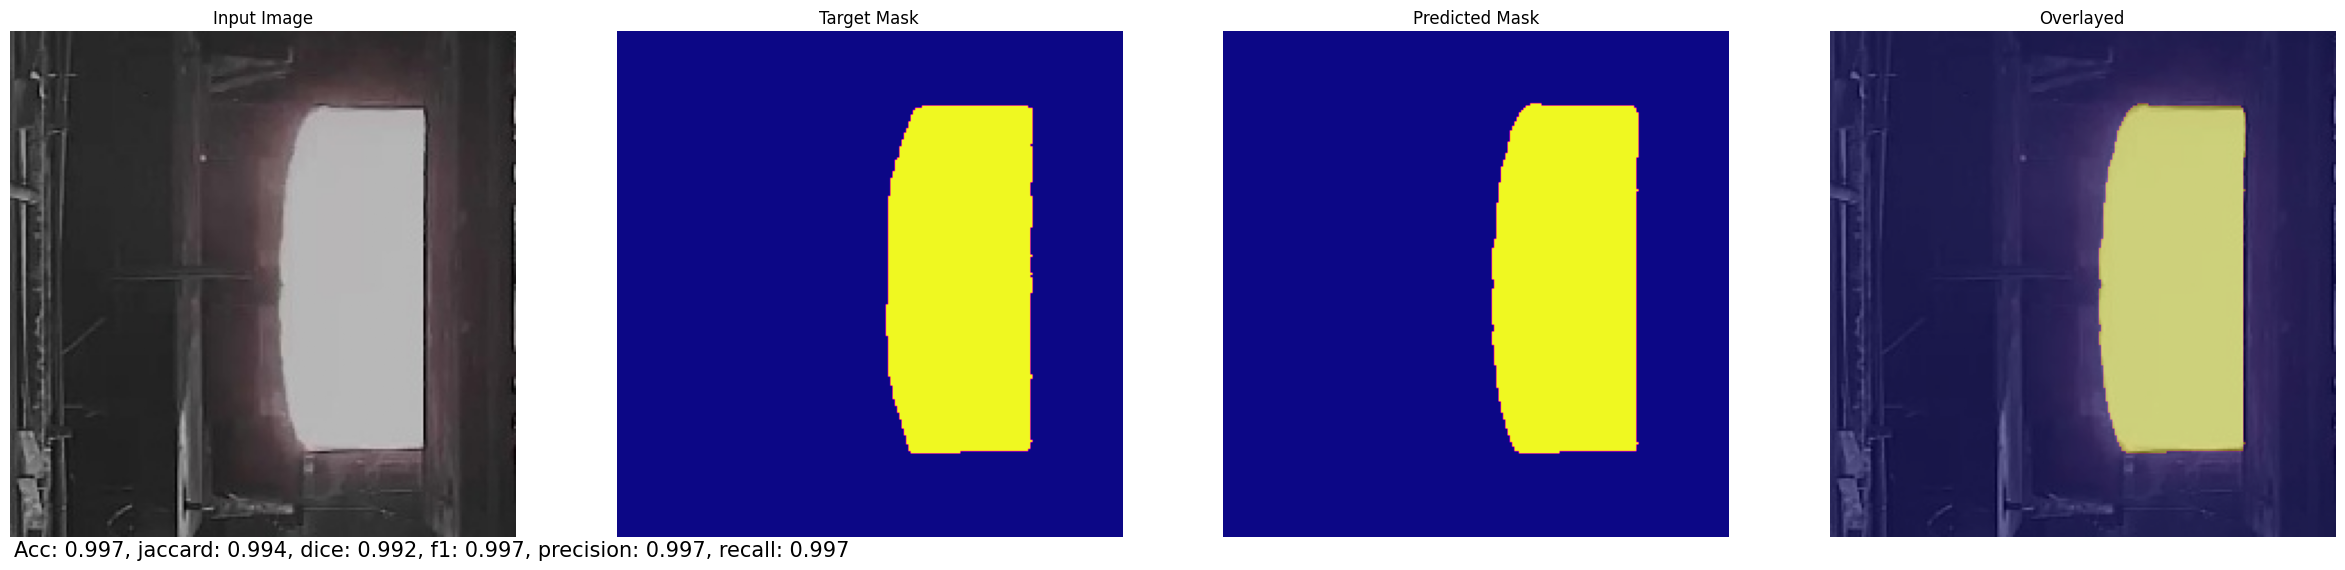

<PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>


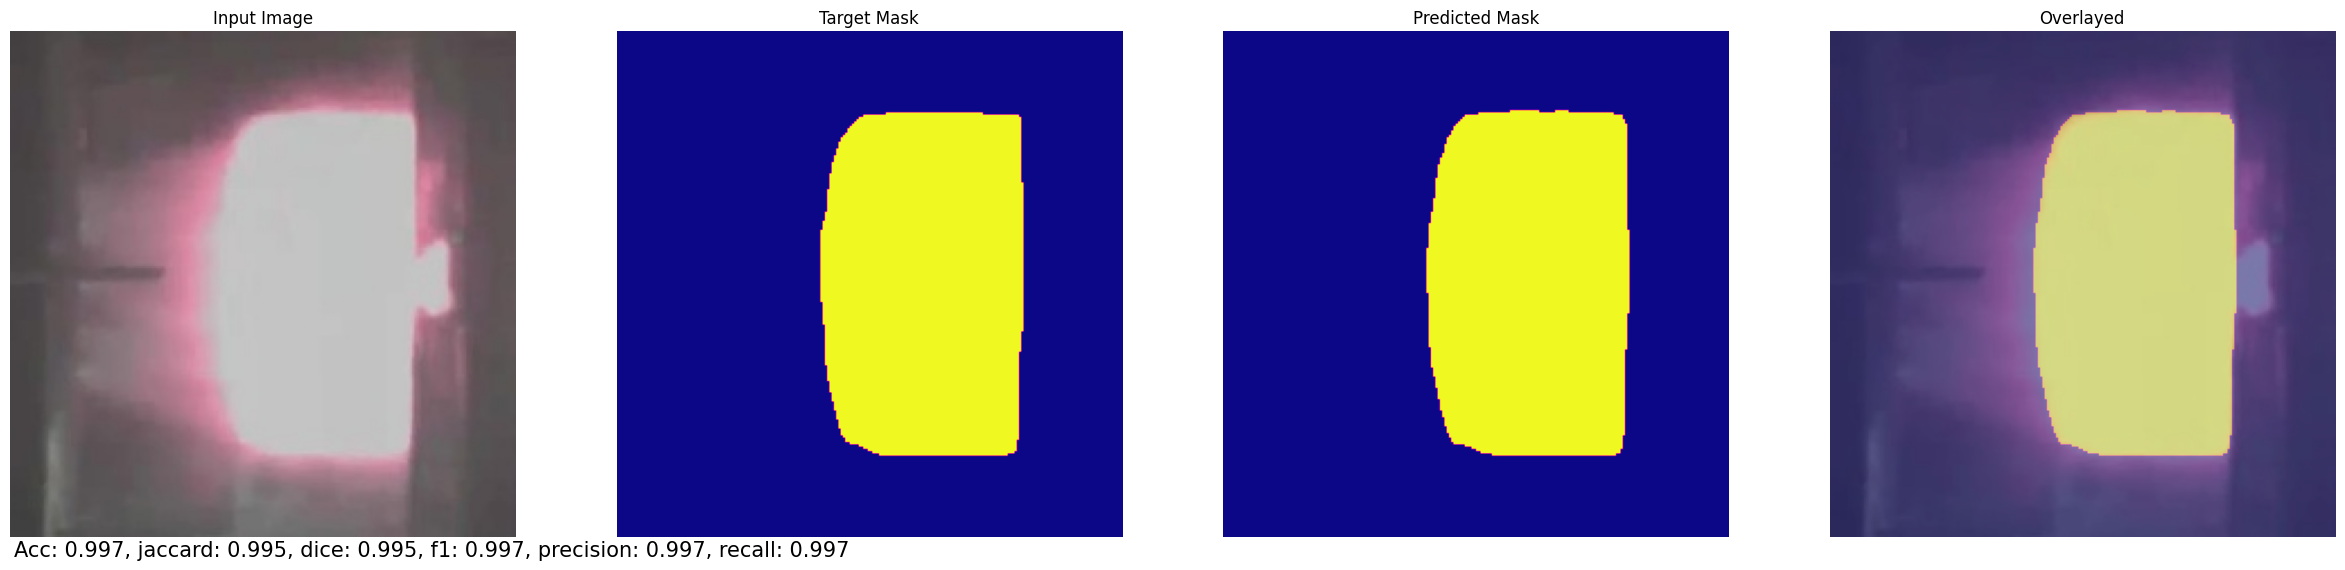

<PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>


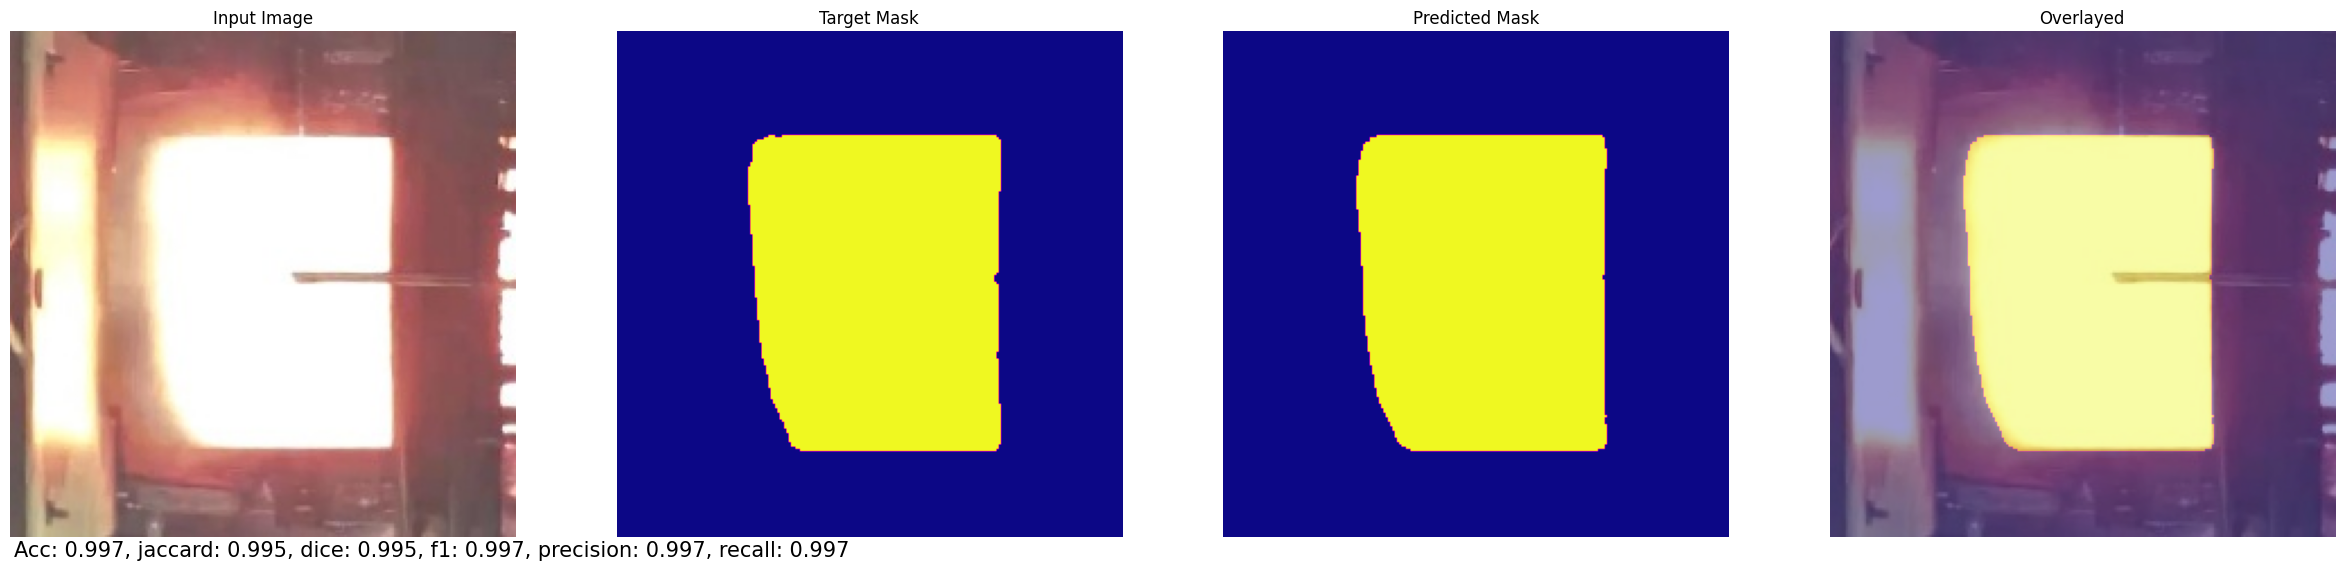

<PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>


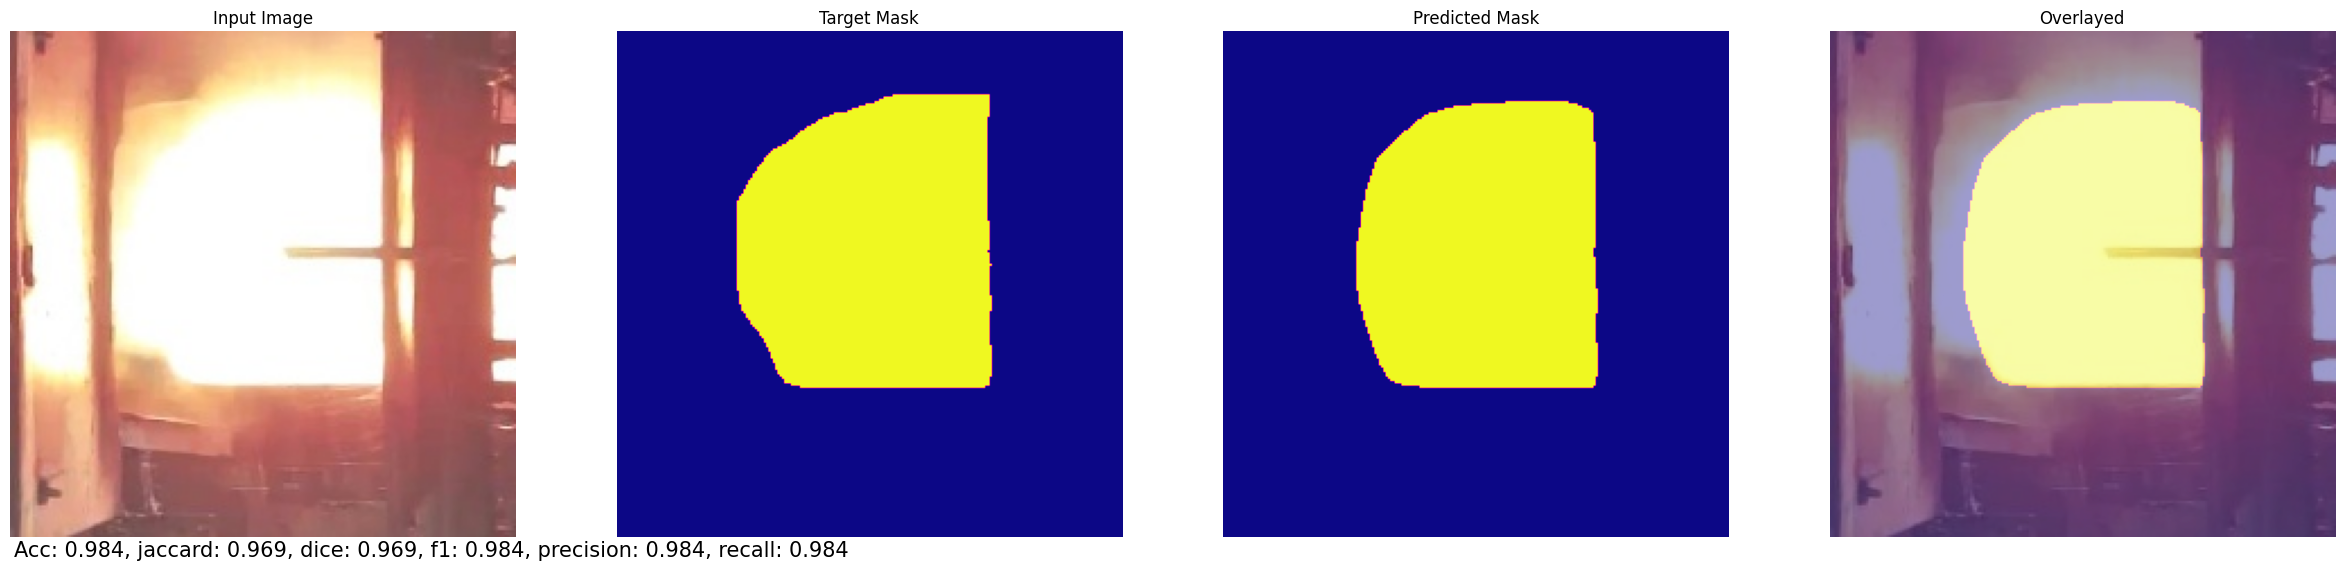

<PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>


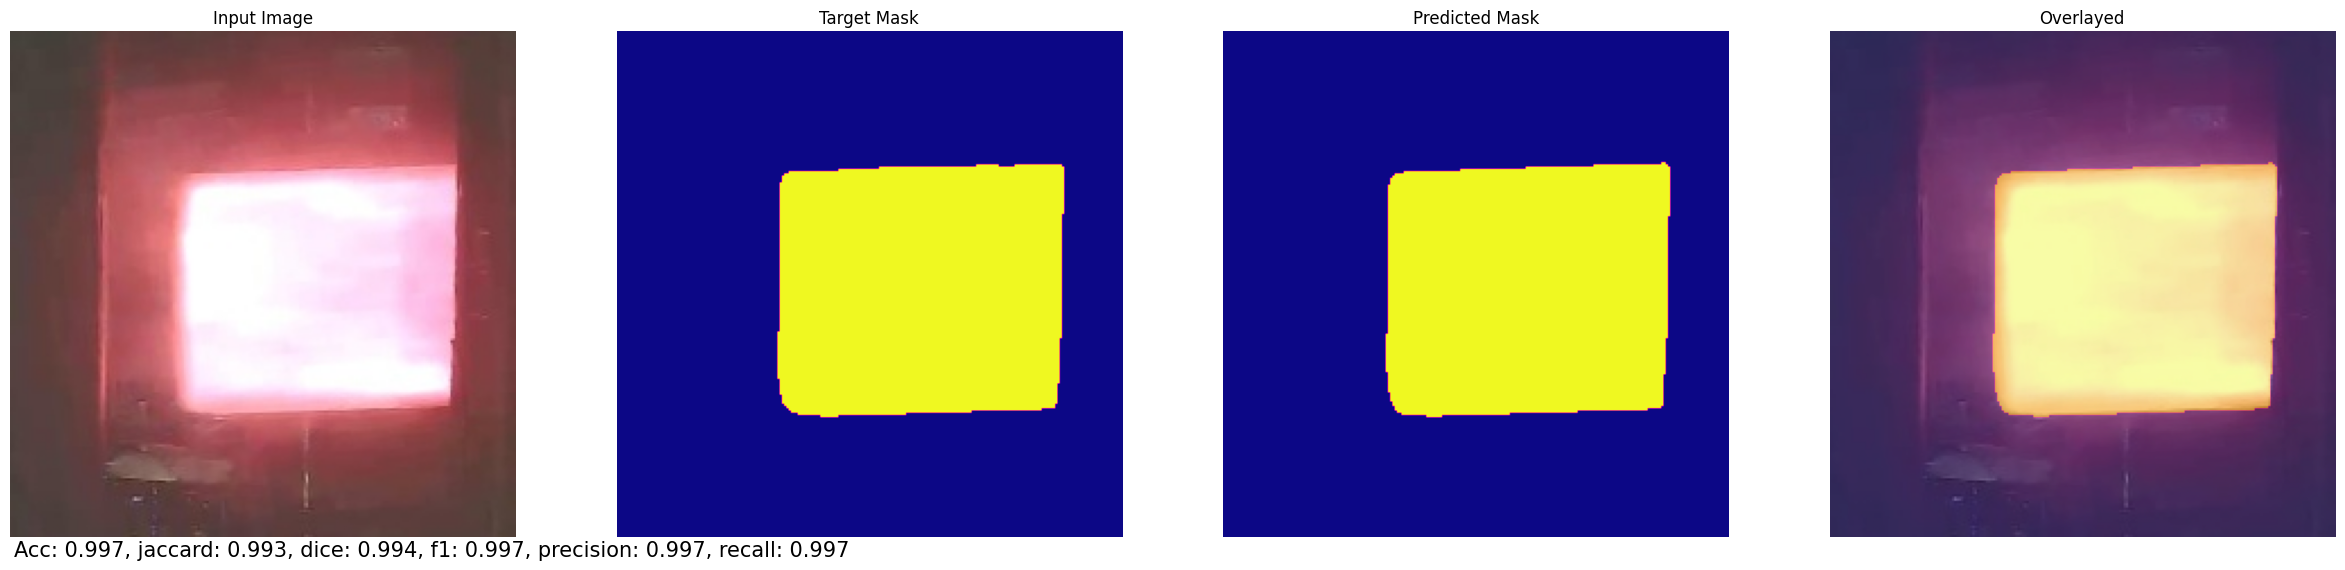

In [66]:
start_directory = r"/home/eferreira/master/mestrado_cnn/projeto_final/semantic_segmentation/dataset/test"

for root, _, files in os.walk(start_directory):
    for file in files[:5]:
        image = os.path.join(root, file)
        show_my_predictions(image)



In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_final = pd.read_csv(r"/home/eferreira/master/mestrado_cnn/projeto_final/semantic_segmentation/results/data.csv")
print(data_final)



     accuracy  jaccard  dice_coef  f1score  precision  recall
0       0.996    0.992      0.988    0.996      0.996   0.996
1       0.997    0.994      0.992    0.997      0.997   0.997
2       0.997    0.995      0.995    0.997      0.997   0.997
3       0.997    0.995      0.995    0.997      0.997   0.997
4       0.984    0.969      0.969    0.984      0.984   0.984
..        ...      ...        ...      ...        ...     ...
394     0.997    0.993      0.992    0.997      0.997   0.997
395     0.995    0.990      0.990    0.995      0.995   0.995
396     0.999    0.998      0.997    0.999      0.999   0.999
397     0.986    0.973      0.970    0.986      0.986   0.986
398     0.998    0.997      0.996    0.998      0.998   0.998

[399 rows x 6 columns]


In [68]:
data_final.describe()

,accuracy,jaccard,dice_coef,f1score,precision,recall
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,0.994815,0.989697,0.985820,0.994815,0.994815,0.994815
std,0.005468,0.010606,0.014245,0.005468,0.005468,0.005468
min,0.959000,0.922000,0.910000,0.959000,0.959000,0.959000
25%,0.994000,0.989000,0.984000,0.994000,0.994000,0.994000
50%,0.997000,0.993000,0.991000,0.997000,0.997000,0.997000
75%,0.998000,0.995000,0.993000,0.998000,0.998000,0.998000
max,1.000000,1.000000,0.999000,1.000000,1.000000,1.000000


In [69]:
import seaborn as sn

# cfmtx = np.zeros((2,2), dtype=np.float64)
# tp = data_final.sum()['tp']
# tn = data_final.sum()['tn']
# fp = data_final.sum()['fp']
# fn = data_final.sum()['fn']
# print(tp)

accuracy = data_final.mean()['accuracy']
f1score = data_final.mean()['f1score']
precision = data_final.mean()['precision']
recall = data_final.mean()['recall']
dice = data_final.mean()['dice_coef']
jaccard = data_final.mean()[5]
print("Accuracy: {:.4f}".format(accuracy))
print("F1Score : {:.4f}".format(f1score))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("Dice: {:.4f}".format(dice))
print("Jaccard: {:.4f}".format(jaccard))

# cfmtx[0][0] = tp
# cfmtx[1][1] = tn
# cfmtx[0][1] = fp
# cfmtx[1][0] = fn


# plt.figure(figsize=(8,6))
# sn.heatmap(cfmtx, annot=True,cmap="YlGnBu",linewidths=.5,fmt='.10g', xticklabels=('corrosion','void'),yticklabels=('corrosion','void'))


Accuracy: 0.9948
F1Score : 0.9948
Precision: 0.9948
Recall: 0.9948
Dice: 0.9858
Jaccard: 0.9948


In [70]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

In [71]:
print(learn.model)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [72]:
target_layer = learn.model[0][7]

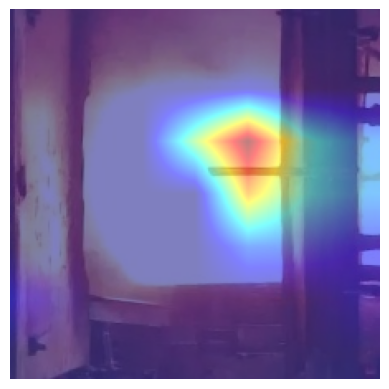

In [73]:

# Carregar e preprocessar a imagem
image_path = '/home/eferreira/master/mestrado_cnn/projeto_final/semantic_segmentation/dataset/test/F4_SUP_TOPO_064_N606581.jpg'
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Converter a imagem para tensor
input_tensor = transform(image).unsqueeze(0)  # Adicionar uma dimensão de batch

# Escolher uma camada do modelo para o Grad-CAM
target_layer = learn.model[0][7]  # Uma das últimas camadas convolucionais antes do upsampling

# Criar o objeto GradCAM
cam = GradCAM(model=learn.model, target_layers=[target_layer])

# Criar uma máscara binária que cobre toda a imagem
mask = np.ones((224, 224), dtype=np.uint8)  # Todos os pixels da imagem

# Definir o alvo da segmentação usando a classe personalizada
target = SemanticSegmentationTarget(category=1, mask=mask)

# Passar o target como uma lista
targets = [target]

# Gerar o CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)  # Agora passando targets como uma lista
grayscale_cam = grayscale_cam[0, :]  # Remover a dimensão do batch

# Converter a imagem original para um numpy array normalizado
rgb_img = np.array(image.resize((224, 224))) / 255.0

# Superpor o CAM na imagem original
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Plotar o resultado
plt.imshow(visualization)
plt.axis('off')
output_path = "results/images/10_cam.png"
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
plt.show()
